# Instructions 

1. Install tensorflow - "pip install tensorflow". Ensure the latest version of tensorflow is installed.   
- Install Keras - "pip install keras". Ensure keras v2.1.3 is installed. 
- Install scipy, numpy and scikit-learn libraries via pip. 
- Install Skimage library 
- Intall altair "pip install altair"
- Install jupyter lab (requied for altair) - "pip install jupyterlab" 
- Install vega3 (required for altair) - "pip install vega3" 
- Keras has been configured to save the model checkpoints in the file system directly. Please ensure the following directory structures are created before running any models 
    - root notebook directory/files
    - root notebook directory/files/keras
    - root notebook directory/files/keras/checkpoints 
    - root notebook directory/files/keras/checkpoints/resnet_checkpoints
    - root notebook directory/files/keras/checkpoints/tensorboardLogs
    
    ** NOTE: tensorboard log command is commented out. If you wish to review tensorboard logs simply uncomment the lines ** 
    
- Sequentially go through each cell and execute the code. It is recommended to look for any instances where you can limit the total number of epochs, iterations etc. to ensure a quick runtime. 
- If memory is an issue on the running instance then simply restart the kernel and execute the desired model post the data load cells (simply load the data and run your desired model instead of all models)
- Keras has been configured to save the best model based on F1-score values. Some sample code has been provided in the appropriate cells (post save) in the event any of the saved models are required to be loaded. 

** NOTE: There are several CPU intensive models in this notebook and taining all of them will require a lot of time (in excess of 6+ hours) **

** Tips for speed up ** 

1. Reduce the total number of epochs carried out by the neural network training
2. Reduce the total number of C values when carrying out grid search 
3. The gridsearchcv call in this notebook spins off 3 jobs in parallel. If you have additional CPUs at your disposal then recommend increasing parallel job numbers. 
4. If you just need to validate the code then simply set the epochs to 1. This will ensure the code executes within 5-10 minutes (depending on the hardware configuration)

# High Level Overview

Total of 3 models build at trained and they are summarised below: 

1. Sift/Daisy Features & SVM 
    - Daisy Feature Extraction Followed by BoVW (Bag of Visual Words) & SVM Radial 
    - Daisy Feature Extraction Followed by BoVW & SVM Linear 
    - SVM Linear using Daisy features directly 
2. Convolutional Neural Network - CNN 
3. Recurrent Neural Network - RNN 
4. Residual Neural Network - ResNet


# Initial Data Load & Visualisation

In [1]:
# necessary libraries 
import pickle
import numpy as np
% matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import itertools

from __future__ import print_function

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report

import keras
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import AveragePooling2D, Input
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.utils import np_utils
from keras.models import Model
import os

from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.color import rgb2gray
from skimage.exposure import equalize_hist
from skimage.filters import threshold_otsu
from skimage.feature import daisy
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


In [2]:
# file load helpers 
_totalBatch = 5
_IMAGE_NORMALISED = False

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def loadTrainigBatch(filepath):
    rawRGBFeatures = None
    trainingLabels = None
    
    for i in range(_totalBatch):
        # load all 5 batches and join the raw RGB data and indexes by row (vstack/hstack)? 
        #print(i+1)
        #print(batch1.keys())
        #print(labelMeta.keys())
        batch = unpickle(filepath + str(i + 1)) # load batch
        if i == 0: 
            rawRGBFeatures = batch.get(b"data")
            trainingLabels = batch.get(b"labels")
        else:
            rawRGBFeatures = np.vstack((rawRGBFeatures,batch.get(b"data")))
            trainingLabels = np.hstack((trainingLabels,batch.get(b"labels")))
    
    return rawRGBFeatures, trainingLabels

def loadHeldOutBatch(filepath):
    rawRGBFeatures = None
    labels = None
    
    batch = unpickle(filepath) # load batch
    rawRGBFeatures = batch.get(b"data")
    labels = np.asarray(batch.get(b'labels'))
    
    return rawRGBFeatures, labels

# image display helpers 
def printRandom10Images(rawData, labels, seed):    
    allImages = np.rot90(np.reshape(rawData, (rawData.shape[0],32,32,3), order='F'), axes=(2,1))
    print("raw image dimensions:", allImages.shape)
    # plot the first 10 random images to verify the conversion
    fig = plt.figure(figsize=(6,3))
    counter = 0
    random.seed(seed)
    for i in random.sample(range(1, rawData.shape[0]), 10):
        ax = fig.add_subplot(2, 5, 1 + counter, xticks=[], yticks=[])
        im = allImages[i,:,:,:] 
        ax.set_title(text_labels[labels[i]])
        plt.imshow(im)
        counter += 1
    plt.show()
    


In [24]:
# Model evaluation helpers 

def plotAxis(model_history, axs, perfName, yLabel):
    # summarize history for Precision
    axs[0].plot(range(1,len(model_history.history[perfName])+1),model_history.history[perfName])
    axs[0].plot(range(1,len(model_history.history['val_' + perfName])+1),model_history.history['val_' + perfName])
    axs[0].set_xticks(np.arange(1,len(model_history.history[perfName])+1),len(model_history.history[perfName])/10)

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    plotAxis(model_history, axs, "acc","Accuracy")
    # summarize history for F1
    plotAxis(model_history, axs, "F1","F-Measure")
    # summarize history for Precision
    #plotAxis(model_history, axs, "Precision","Precision")
    # summarize history for Recall
    #plotAxis(model_history, axs, "Recall","Recall")
    
    axs[0].set_title('Model Performance Metrics over the epochs')
    axs[0].set_ylabel('Performance Measures')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train acc', 'val acc', 'train F1', 'val F1' ], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    
    plt.show()
    
def drawROCCurves(y_true, y_pred): 
    y_true = label_binarize(y_true, classes=labels)
    y_pred = label_binarize(y_pred, classes=labels)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i]) 
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure(figsize=(10,7))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
        
    # plot all the class ROCs
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2,label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(text_labels[i], roc_auc[i]))
        
    # Plot micro-avg ROC curve
    
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["micro"]),color='deeppink', linestyle=':', linewidth=6)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC of model')
    plt.legend(loc="lower right")
    
def plot_confusion_matrix(cm,
                          title='Cifar10 Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(10,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(text_labels))
    plt.xticks(tick_marks, text_labels, rotation=45)
    plt.yticks(tick_marks, text_labels)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def CNN_Predict(test_x, model):
    result = model.predict(test_x)
    y_pred = np.argmax(result, axis=1)
    return y_pred

def EvaluateModel(y_test, y_pred): 
    
    # over all accuracy 
    accuracy = (np.sum(y_pred == y_test)/y_test.shape[0])*100
    print("Accuracy of model is: %0.2f"%accuracy)
    
    # confusion matrix 
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, "Confusion Matrix")
    # print out the classification report 
    print(classification_report(y_test, y_pred, target_names=text_labels))
    # draw the ROC Curve
    drawROCCurves(y_test, y_pred)

# keras custom metrics 
def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def F1(y_true, y_pred):
    p = Precision(y_true, y_pred)
    r = Recall(y_true, y_pred)
    f1 = 2*(r * p) / (r + p)
    return f1

In [3]:
# file loads - raw data + numerical labels + text labels

rawRGBFeatures, trainingLabels = loadTrainigBatch("data/cifar-10-batches-py/data_batch_")
labelMeta = unpickle("data/cifar-10-batches-py/batches.meta") # load the label metadata
text_labels = [x.decode("utf-8") for x in labelMeta.get(b"label_names")] # to convert from byte literal to string

print(rawRGBFeatures.shape)
print(trainingLabels.shape)

# extraction unique labels 
labels = np.unique(trainingLabels)
print(labels)
print(text_labels)

(50000, 3072)
(50000,)
[0 1 2 3 4 5 6 7 8 9]
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
# load the held out dataset 
holdOutRawFeatures, holdOutLabels = loadHeldOutBatch("data/cifar-10-batches-py/test_batch")
print(holdOutRawFeatures.shape)
print(holdOutLabels.shape)

(10000, 3072)
(10000,)


raw image dimensions: (50000, 32, 32, 3)


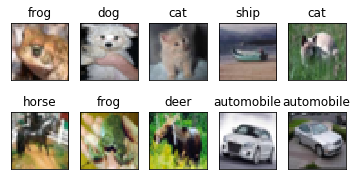

In [5]:
# print random 10 images
printRandom10Images(rawRGBFeatures,trainingLabels, seed=5)

## Normalise the images (RGB) 

At times, you want to get rid of distortions caused by lights and shadows in an image. Normalizing the RGB values of an image can at times be a simple and effective way of achieving this.

When normalizing the RGB values of an image, you divide each pixel's value by the sum of the pixel's value over all channels. So if you have a pixel with intensitied R, G, and B in the respective channels... its normalized values will be R/S, G/S and B/S (where, S=R+G+B).

normalising
Images from the training set
raw image dimensions: (50000, 32, 32, 3)


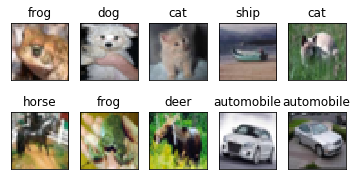

Images from the held out set
raw image dimensions: (10000, 32, 32, 3)


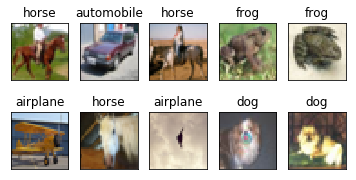

In [6]:
# normalise 
rawRGBFeatures = rawRGBFeatures.astype("float32") # convert the dataset to float32
holdOutRawFeatures = holdOutRawFeatures.astype("float32") 
if not _IMAGE_NORMALISED: 
    print("normalising")
    rawRGBFeatures = rawRGBFeatures/255 # normalise by dividing by 255
    holdOutRawFeatures = holdOutRawFeatures/255
    _IMAGE_NORMALISED = True
# now plot again to see verify the image quality 
print("Images from the training set")
printRandom10Images(rawRGBFeatures, trainingLabels, seed=5)
print("Images from the held out set")
printRandom10Images(holdOutRawFeatures, holdOutLabels, seed=5)


In [7]:
# split the data into train and test splits (80/20)

from sklearn.model_selection import train_test_split

train_data, eval_data, train_labels, eval_labels = train_test_split(rawRGBFeatures, trainingLabels, test_size=0.20, random_state=42)

train_data = train_data.astype("float32")
train_labels = train_labels.astype("float32")
eval_data = eval_data.astype("float32")
eval_labels = eval_labels.astype("float32")

print(train_data.shape)
print(train_labels.shape)
print(eval_data.shape)
print(eval_labels.shape)


(40000, 3072)
(40000,)
(10000, 3072)
(10000,)


#  Classification Methods 

Image Classifications are complex tasks that require extraction of features and key attributes from images before they can be pumped into a model for classification. Often times, these feature extraction processes impose a massive challenge as images come in all manners of sizes (dimensions), lighting conditions, intensities of pixels, angles, scale etc. This makes it difficult for a computer to understand the key features before a classification can be carried out. 
Although in humans understanding & processing images comes as a second nature, the in the field of computer vision the computer simply gets a large array of numbers to process. The figure below depicts a clear picture of this challenge. 

![Computer vision vs human vision](images/whatwesee.png "Figure 1: Computer vision vs our vision")
 
Figure 1: Computer vision vs our vision 
(https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/) 

**Background on SIFT (Scale Invariant Feature Transformation)** 
There are several techniques to extract features from images such has Histogram of Gradients (HoG), Binarizing and blurring, corner detection (Corner Harris and corner peak) but by far the most widely used method is SIFT keypoint detector. 
Sift is effective due to the fact that it is able to detect/match features between images even if the scale, orientation, viewpoint, and illumination are different between images. The SIFT algorithm takes a grayscale image and generates interest points (keypoints) from the image where the local gradient orientation histograms of the image intensities are collected and statistically summarized to produce a keypoint descriptor of the local image structure (Prof. Tony Lindeberg, 2012, Scholarpedia, 7-5:10491). Typically, these statistics are gathered from a surrounding neighborhood of each keypoint. 
We have opted to utilize a variation of SIFT (since it is a proprietary algorithm) called “Daisy feature extractor” which is available in the scikit image library. Once these descriptors from each image captured they can be utilized for image classification tasks as well as image matching. 

**Background on Multi-Layer Neural Network**
The key advantage of a multi-layer neural net is that is able to predict and model on any distribution of data and able to create non-linear decision boundaries. The figure below depicts a simple artificial neural net and also a multilayer neural net. 

Simple multi-layer network | Single Neuron
- | - 
![Multilayer Neural Network](images/SampleNetwork.png "Mulilayer neural network") | ![Multilayer Neural Network](images/simpleNeuron.png "Figure 2: Single Neuron")
 
Figure 2: Stanford University depiction of a generic feedforward multi-layer neural network. 

The key concepts of a neural nets are the inputs, neurons, the weights and bias terms, the output/activation function, and the optimization function (gradient descent/backpropagation). Each circle depicted in the image above is a single neuron or a computation unit which takes in the input (x1, x2, x3, and the bias unit) and outputs some new x via an activation function. The output from one neuron is then passed onto (feed forward) to the next layer of neurons which in turn carries out a similar exercise of applying an activation function. 

There are several activation functions that are in practice but for our exercise we have opted to utilize a Rectified Linear Function (ReLU). Recent research suggests that ReLU activations perform better in practice in deep neural networks when compared it its counterparts (UFLDF Tutorial on multilayer neural network – Stanford University). The formula that runs through each of the neurons in our case can be summarised below (where n is the number of x inputs and f is the activation function) - 

\begin{equation*}
\begin{aligned}
h_{W,b}(x) = f(W^Tx) = f(\sum_{i=1}^n W_{i}x_{i} + b)
\\f(z) = max(0, x)
\end{aligned}
\end{equation*}

Optimizations in a neural network is carried out with gradient descent however, there are several layers within a deep neural network therefore we utilized backpropagation to optimize the weights within the network. Backpropagation simply put, allows the easy calculation of the partial derivatives of the cost functions for each layer. The chain rule allows easy calculation of the derivative of the overall cost function (UFLDF Tutorial on multilayer neural network – Stanford University). The formula of the derivative of the overall cost function for the network is outlined below.

\begin{equation*}
\begin{aligned}
f'([z_1, z_2, z_3 ...]) = [f'(z_1),f'(z_2),f'(z_3),...] \\
\frac{\partial}{\partial W_{ij}^{(l)}} J(W, b) = \biggl[ \frac{1}{m} \sum_{i=1}^m \frac{\partial}{\partial W_{ij}^{(l)}} J(W, b; x^{(i)}, y^{(i)}) \biggr] + \lambda W_{ij}^{(l)} \\
\frac{\partial}{\partial b_{ij}^{(l)}} J(W, b) = \frac{1}{m} \sum_{i=1}^m \frac{\partial}{\partial b_{ij}^{(l)}} J(W, b; x^{(i)}, y^{(i)})
\end{aligned}
\end{equation*}

Our chosen dataset (Cifar10) is such a problem where we have thousands of 32x32 images containing 10 distinct classes of objects. We have opted to approach this classification task from a chronological technology/technique/method in the field of computer vision. 

Below is a list of methods that we have attempted in chronological order

- **Sift/Daisy Feature Extraction Followed by Classification**

Before the advent of more modern techniques such as convolutional neural networks the field of computer vision utilized several scale invariant algorithms (Sift, Surf) to carry out manual feature curation/extraction before pumping the said features into a classification algorithm. Although a lot of algorithms have been developed to extract features this is still a manual, unreliable, and inconstant methodology that hardly yielded good performance.

- **Convolutional Neural Network (CNN)**

A more modern approach in the field of computer vision where we utilize an artificial neural network alongside a technique/methodology of convolutions to understand features and predict the image classes after passing it through a multi-layer neural network. This method yields a high degree of accuracy and able to understand more complex distributions of the data.

- ** Recurrent Neural Network (RNN – LSTM & GRU) **

- **Residual Neural Network (ResNet)**

Another variation of a multi-layer neural network that still utilizes convolutions in the heart but with a slight twist called “short-cuts” that addresses the vanishing gradient problem in a deep neural network and thereby allows build and construction of deeper networks. ResNets are able to understand even more complex features simply via the convent of a deeper network and ability to train deeper for longer. 


# Sift/Daisy Features & SVM 

For this experiment we have opted to take a classical approach to image classification. Before the advent of CNNs and ResNets bulk majority of the image classifications involved manual curation of features before passing the features into a classifier. For our experiment we have opted to utilise Daisy (part of the Scikit image library) to extract the feature descriptors of key points identified from the images and then utilising an old school SVM to classify the images. We have taken 2 slight variations to this approach. 
- Daisy Feature + BoVW (Bag of Visual Words) + SVM (Radial & Linear) 
- Daisy Feature + SVM Linear 

** Theory ** 

Daisy similar to SIFT is able to detect and generate feature descriptors for image matching from a grayscale image. According to the authors of the algorithm the algorithm utilises gaussian weighting and circularly symmetrical kernel alongside Histogram of Gradients to generate local image descriptors [4]. The algorithm requires specification of circle radius, number of circles/rings, and the step. Given that we have a small 32x32 image space we have opted to proceed with a step of 4, with a circle radius of 5 to maximise the number of feature descriptors learnt from the images. Daisy is suitable for BoVW feature generation and also allows for fast dense extraction of features (Scikit image documentation). 

BoVW [5] is a technique for generation of a vocabulary or a codebook from key points of interest from an image. In typical sense we can use a bag of words to carry out a text classification. However, since we are dealing with an image we have to first develop a codebook so that we can generate a bag of words. In our approach we have attempted to generate the codebook utilising a k-means clustering algorithm to develop the codebook. Later the codebook can be utilised to generate the bag of visual words for any given image. A rudimentary way to explain this process is that k-means clustering allows us to develop a dictionary of words such as wheels in the case of cars and then look for wheels within a newly extracted daisy feature. An intuitive way to think of this process is that we end up learning the key features that identify an object from other objects (e.g. cars have wheels but not people). 

Once we have the vocabulary generated the next step is to develop a bag of visual words for a given image. In simple terms, this is simply a process of looking at how many times a specific visual word occurred in a given image. This is done by generating a histogram of occurrences of words within an image. Generating the BoVW also acts as a means of dimensionality reduction through the process of Daisy, K-Means, & Histogram generation as it effectively shrinks the entire image set to a set of visual words only. 

Once we have to features identified and generated (BoVW or Daisy) we can utilise any number of classifiers to define the decision boundary. However out of all the pool of classifiers at our disposal we have opted to utilise SVM for several key reasons. The primary reason behind our use of SVM is that it is able to define non-linear decision boundaries. The second reason is that SVMs have regularisation parameters which allows us to penalise the algorithm for overfitting on the training data. Thirdly, we have the choice of kernels at our disposal which allows us to engineer various different types of kernels that best suits our dataset. For our exercise we have opted to utilise both the radial and linear kernel. 

In [11]:
# helpers for image feature extraction and processing 
_codebook = None
_scaler = None
num_classes = 10

def show_images(images,titles=None):
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure(figsize=(1.5,1.5))
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray() 
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()
    
def ConvertToGray(RGBArray):
    grayImages = np.empty((RGBArray.shape[0],32,32))
    for i in range(RGBArray.shape[0]):
        # convert
        gray_image = rgb2gray(RGBArray[i,:,:,:])
        grayImages[i] = gray_image[np.newaxis,:,:]
    return grayImages

def extractDaisyFeatures(grayImages):
    bov_descriptors = np.empty((grayImages.shape[0],36,130))

    for i in range(grayImages.shape[0]):
        img = grayImages[i,:,:]
        descs = daisy(img, step=4, radius=5, rings=2, histograms=6, orientations=10, visualize=False) # 48%
        descsTransformed = descs.reshape((-1 ,descs.shape[2])) # flatten the features dimensions
        bov_descriptors[i] = descsTransformed

    return bov_descriptors

# extract flattened daisy features
def getDaisyFeatures(grayImages, steps, radius, rings):
    bov_descriptors = None
    for i in range(grayImages.shape[0]):
        img = grayImages[i,:,:]
        descs = daisy(img, step=steps, radius=radius, rings=rings, visualize=False) 
        descsTransformed = descs.reshape(1, -1) # flatten the features dimensions
        if bov_descriptors is None:
            # initialise 
            bov_descriptors = np.empty((grayImages.shape[0],descsTransformed.shape[1]))
            bov_descriptors[i] = descsTransformed
        else: 
            bov_descriptors[i] = descsTransformed
            
    return bov_descriptors

# generate the bag of visual words for classification
def GenerateBOVW(numClusters, descriptor_list, codebook):
    n_images = descriptor_list.shape[0]
    mega_histogram = np.array([np.zeros(numClusters) for i in range(n_images)])
    old_count = 0
    for i in range(n_images):
        l = len(descriptor_list[i])
        for j in range(l):
            idx = codebook[old_count+j]
            mega_histogram[i][idx] += 1
        old_count += l

    # standardise to offset bias
    scaler = StandardScaler().fit(mega_histogram)
    mega_histogram = scaler.transform(mega_histogram)
    
    return mega_histogram, scaler

def ConvertToBoVW(bwImages,kmeansModel,numWords=150): 
    
    # generate the daisy features
    descriptors = extractDaisyFeatures(bwImages)
    bov_descriptors = descriptors.reshape((-1, descriptors.shape[2]))

    codebook = kmeansModel.predict(bov_descriptors)
    
    # generate BoVW
    vocab = np.array([np.zeros(numWords) for i in range(bwImages.shape[0])])
    
    old_count = 0
    for i in range(bwImages.shape[0]):
        l = len(descriptors[i])
        for j in range(l):
            idx = codebook[old_count+j]
            vocab[i][idx] += 1
        old_count += l
    
    # scale using a saved scaler
    vocab = _scaler.transform(vocab)
    
    return vocab

Shape of train dataset: (40000, 32, 32, 3)
Shape of train labels: (40000,)
Shape of test dataset: (10000, 32, 32, 3)
Shape of test labels: (10000,)
Shape of train set: float32
shape of test set: float32
Procesing took 1.56 seconds
shape of dataset after conversion to grayscale: (40000, 32, 32)


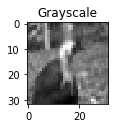

In [21]:
# prep the dataset for training and testing 
xTrain = np.rot90(np.reshape(train_data, (40000,32,32,3), order='F'), axes=(2,1))
xTest = np.rot90(np.reshape(eval_data, (10000,32,32,3), order='F'), axes=(2,1))
# convert the labels to one hot encoded values
y_train = keras.utils.to_categorical(train_labels, num_classes)
y_test = keras.utils.to_categorical(eval_labels, num_classes)

y_train = y_train.argmax(axis=1)
y_test = y_test.argmax(axis=1)

print("Shape of train dataset:", xTrain.shape)
print("Shape of train labels:", y_train.shape)

print("Shape of test dataset:", xTest.shape)
print("Shape of test labels:", y_test.shape)

xTrain = xTrain.astype("float32")
print("Shape of train set:", xTrain.dtype)

xTest = xTest.astype("float32")
print("shape of test set:", xTest.dtype)

# prep the dataset for training and testing 
# convert the images to grayscale 
start = time.time()
grayImages = ConvertToGray(xTrain)
print("Procesing took %0.2f seconds"%(time.time() - start))

# visualise the transformation
print("shape of dataset after conversion to grayscale:", grayImages.shape)
gray_image = grayImages[1,:,:]

show_images(images=[gray_image],
           titles=["Grayscale"])


### Extract the Daisy features from all the grayscale images

In [14]:
# generate some SIFT features from the training set
#grayImages2d = grayImages.reshape((grayImages.shape[0], 1024)) # convert to 2d array if images
start = time.time()
descriptor_list = extractDaisyFeatures(grayImages)
print("Procesing took %0.2f seconds"%(time.time() - start))
print("shape of the keypoint descriptor set:", descriptor_list.shape)

Procesing took 101.70 seconds
shape of the keypoint descriptor set: (40000, 36, 130)


### Develop the codebook/Dictionary for the BoVW

Clustering range search took 368.21 seconds


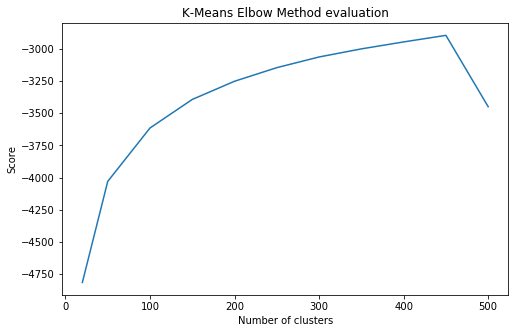

In [15]:
# carry out a k-means clustering 

# reshape to flatten the features dimensions
bov_descriptors = descriptor_list.reshape((-1, descriptor_list.shape[2]))

start = time.time()
range_n_clusters = [20,50,100,150,200,250,300,350,400,450,500]
#range_n_clusters = [350,400,450,500]
km = [MiniBatchKMeans(n_clusters=i,batch_size=200) for i in range_n_clusters]
score = [km[i].fit(bov_descriptors).score(bov_descriptors) for i in range(len(range_n_clusters))]
print("Clustering range search took %0.2f seconds"%(time.time() - start))

# plot to find the best K for the codebook for maximum explainability
plt.figure(figsize=(8,5))
plt.title("K-Means Elbow Method evaluation")
plt.plot(range_n_clusters, score)
plt.ylabel('Score')
plt.xlabel('Number of clusters')

In [18]:
# create bag of visual words 

# prep the best codebook
bestk = 450
visualWords = km[9].predict(bov_descriptors)
_codebook = km[9]

start = time.time()
BOVW, _scaler = GenerateBOVW(bestk, descriptor_list, visualWords)
print("Time taken to generate codebook: %0.2f seconds"%(time.time() - start))
print(BOVW.shape)

Time taken to generate codebook: 1.93 seconds
(40000, 450)


In [19]:
# convert the evaluation set for testing the classifier

start = time.time()
grayImages = ConvertToGray(xTest)
print(grayImages.shape)
testWords = ConvertToBoVW(grayImages,_codebook,numWords=bestk)
print("Feature extraction on test data took %0.2f seconds"%(time.time() - start))

(10000, 32, 32)
Feature extraction on test data took 28.64 seconds


### SVM Radial with BoVW

SVM training took 1169.90 seconds
Prediction operation took 194.14 seconds
SVM training took 942.52 seconds
Prediction operation took 196.35 seconds
SVM training took 1024.78 seconds
Prediction operation took 201.05 seconds
SVM training took 1077.30 seconds
Prediction operation took 189.85 seconds
SVM training took 1295.15 seconds
Prediction operation took 196.18 seconds


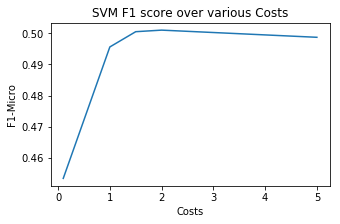

In [22]:
# train and test the model 

from sklearn.metrics import f1_score

Cs = [0.1, 1, 1.5, 2, 5]
f1s = list()

best_svm_clf = None
currentBest = 0.

for c in Cs:
    f1_current = 0.
    clf = SVC(C=c,cache_size=1200,class_weight="balanced")
    start = time.time()
    clf.fit(BOVW, y_train)
    print("SVM training took %0.2f seconds"%(time.time() - start))
    start = time.time()
    preds = clf.predict(testWords)
    print("Prediction operation took %0.2f seconds"%(time.time() - start))
    
    f1_current = f1_score(y_test, preds, average='micro')
    if f1_current >= currentBest:
        currentBest = f1_current
        # save the model 
        best_svm_clf = clf
    f1s.append(f1_current)

plt.figure(figsize=(5,3))
plt.title("SVM F1 score over various Costs")
plt.plot(Cs, f1s)
plt.ylabel('F1-Micro')
plt.xlabel('Costs')


(10000, 32, 32, 3)
(10000,)
(10000, 32, 32)
Feature extraction on test data took 25.38 seconds
Prediction operation took 192.96 seconds
Accuracy of model is: 50.52
             precision    recall  f1-score   support

   airplane       0.59      0.58      0.59      1000
 automobile       0.53      0.59      0.56      1000
       bird       0.39      0.37      0.38      1000
        cat       0.36      0.31      0.33      1000
       deer       0.40      0.40      0.40      1000
        dog       0.46      0.48      0.47      1000
       frog       0.55      0.59      0.57      1000
      horse       0.57      0.52      0.54      1000
       ship       0.62      0.64      0.63      1000
      truck       0.54      0.57      0.56      1000

avg / total       0.50      0.51      0.50     10000



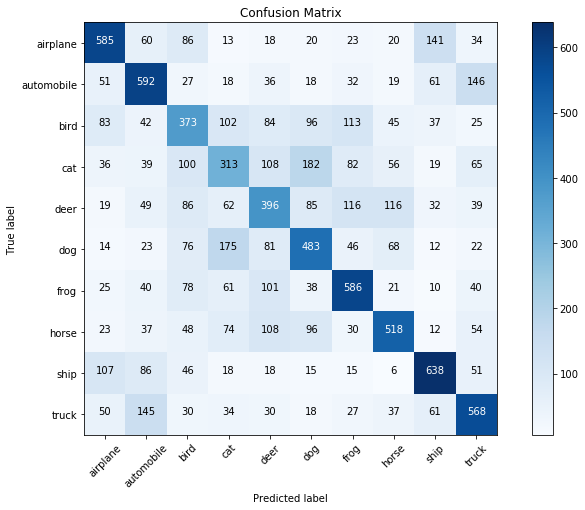

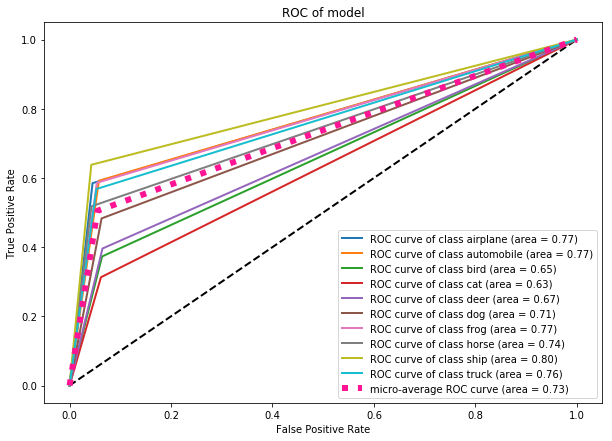

In [25]:
# test on the hold out dataset 

xHoldOut = np.rot90(np.reshape(holdOutRawFeatures, (10000,32,32,3), order='F'), axes=(2,1))
print(xHoldOut.shape)
print(holdOutLabels.shape)

# generate the words from the codebook
start = time.time()
grayImages = ConvertToGray(xHoldOut)
print(grayImages.shape)
holdOutWords = ConvertToBoVW(grayImages,_codebook,numWords=bestk)
print("Feature extraction on test data took %0.2f seconds"%(time.time() - start))

# predict using the best svm classifier
start = time.time()
preds = best_svm_clf.predict(holdOutWords)
print("Prediction operation took %0.2f seconds"%(time.time() - start))

# evaluatate the model
EvaluateModel(y_pred=preds, y_test=holdOutLabels)

### Linear SVC with BoVW 

In [26]:
# train using a linear SVC for performance gains

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

#range_n_clusters = [20,50,100,150,200,250,300]
# play around with different K means 

# prep the best codebook
_codebook = km[10]
bestk = 500
visualWords = _codebook.predict(bov_descriptors)

start = time.time()
BOVW, _scaler = GenerateBOVW(bestk, descriptor_list, visualWords)
print("Time taken to generate codebook: %0.2f seconds"%(time.time() - start))
print(BOVW.shape)

# convert the evaluation set for testing the classifier

start = time.time()
grayImages = ConvertToGray(xTest)
print(grayImages.shape)
testWords = ConvertToBoVW(grayImages,_codebook,numWords=bestk)
print("Feature extraction on test data took %0.2f seconds"%(time.time() - start))

# convert the hold out dataset 
# generate the words from the codebook
start = time.time()
grayImages = ConvertToGray(xHoldOut)
print(grayImages.shape)
holdOutWords = ConvertToBoVW(grayImages,_codebook,numWords=bestk)
print("Feature extraction on hold out data took %0.2f seconds"%(time.time() - start))

Time taken to generate codebook: 2.00 seconds
(40000, 500)
(10000, 32, 32)
Feature extraction on test data took 25.55 seconds
(10000, 32, 32)
Feature extraction on hold out data took 26.58 seconds


In [27]:
# carry out 10 fold cross validation and a grid search for best C
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

cvparameters = {'C':[1, 2, 3, 5, 10, 100]}
cvscoring = {'f1-micro': make_scorer(f1_score,average='micro')}
clf_svc_lin = GridSearchCV(LinearSVC(random_state=42,dual=False,class_weight="balanced"),
                           cvparameters,scoring=make_scorer(f1_score,average='micro'), 
                           cv=10, refit='f1-micro',n_jobs=3,verbose=5)
clf_svc_lin.fit(BOVW, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] .............................. C=1, score=0.456044, total=  44.1s
[CV] C=1 .............................................................
[CV] .............................. C=1, score=0.463902, total=  49.3s
[CV] C=1 .............................................................
[CV] .............................. C=1, score=0.455159, total=  54.5s
[CV] C=1 .............................................................
[CV] .............................. C=1, score=0.460520, total=  46.4s
[CV] C=1 .............................................................
[CV] .............................. C=1, score=0.454636, total=  43.3s
[CV] C=1 .............................................................
[CV] ...........

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  3.1min


[CV] .............................. C=2, score=0.460520, total=  45.8s
[CV] C=2 .............................................................
[CV] .............................. C=2, score=0.454636, total=  42.6s
[CV] C=2 .............................................................
[CV] .............................. C=2, score=0.455159, total=  57.0s
[CV] C=2 .............................................................
[CV] .............................. C=2, score=0.461615, total=  42.7s
[CV] C=2 .............................................................
[CV] .............................. C=2, score=0.464750, total=  44.5s
[CV] C=2 .............................................................
[CV] .............................. C=2, score=0.452452, total=  43.2s
[CV] C=3 .............................................................
[CV] .............................. C=2, score=0.459960, total=  39.5s
[CV] C=3 .............................................................
[CV] .

[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed: 14.5min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'C': [1, 2, 3, 5, 10, 100]}, pre_dispatch='2*n_jobs',
       refit='f1-micro', return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=5)

0.458825


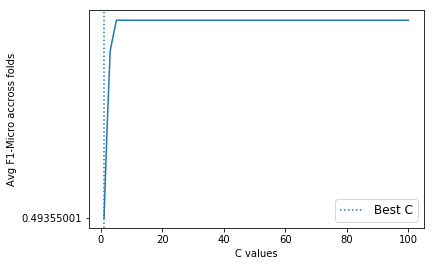

In [37]:
#print(clf_svc_lin.cv_results_
print(clf_svc_lin.best_score_)

avg_f1s = np.array(clf_svc_lin.cv_results_.get("mean_train_score"))
plt.xlabel('C values')
plt.ylabel('Avg F1-Micro accross folds')
plt.plot(cvparameters.get("C"),avg_f1s)
plt.yticks(np.arange(avg_f1s.min(), avg_f1s.max(), 0.1))
plt.axvline(clf_svc_lin.best_estimator_.C,
            linestyle=':', label='Best C')
plt.legend(prop=dict(size=12))
plt.show()

Prediction operation took 0.01 seconds
Accuracy of model is: 45.68
             precision    recall  f1-score   support

   airplane       0.52      0.48      0.50      1000
 automobile       0.48      0.60      0.54      1000
       bird       0.38      0.26      0.31      1000
        cat       0.35      0.18      0.24      1000
       deer       0.39      0.30      0.34      1000
        dog       0.43      0.51      0.46      1000
       frog       0.45      0.61      0.52      1000
      horse       0.47      0.48      0.48      1000
       ship       0.53      0.63      0.57      1000
      truck       0.47      0.51      0.49      1000

avg / total       0.45      0.46      0.44     10000



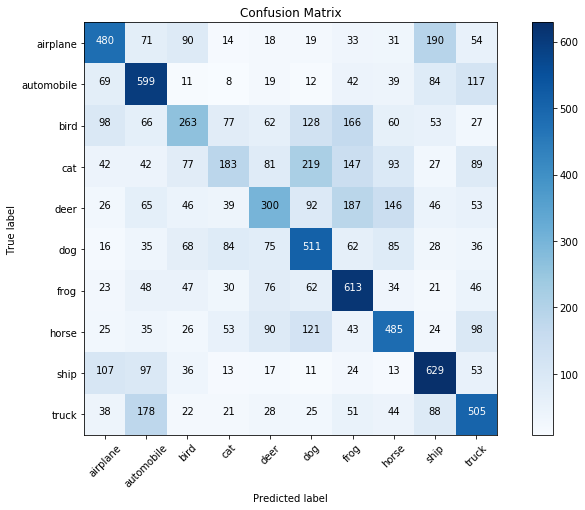

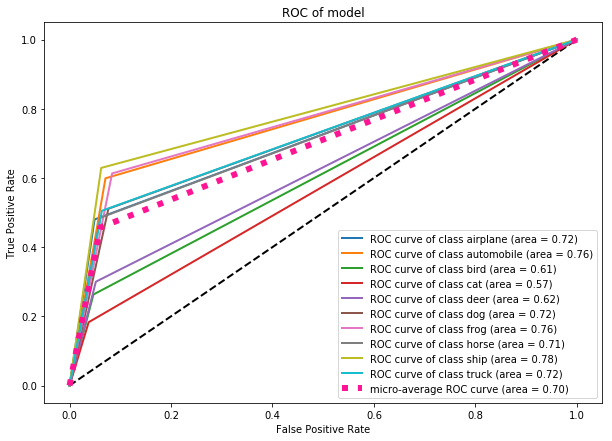

In [38]:
# predict using the best svm classifier
start = time.time()
preds = clf_svc_lin.predict(holdOutWords)
print("Prediction operation took %0.2f seconds"%(time.time() - start))

# evaluatate the model
EvaluateModel(y_pred=preds, y_test=holdOutLabels)

### Linear SVC with Raw Daisy Features

In [ ]:
# Generate the feature descriptors 
xTrain = np.rot90(np.reshape(rawRGBFeatures, (50000,32,32,3), order='F'), axes=(2,1))
grayImages = ConvertToGray(xTrain)
print(grayImages.shape)

start = time.time()
descriptor_list = getDaisyFeatures(grayImages,steps=4,radius=9,rings=2)
print("Procesing took %0.2f seconds"%(time.time() - start))

print(descriptor_list.shape)

(50000, 32, 32)
Procesing took 113.75 seconds
(50000, 2176)


In [ ]:
# carry out a grid search over a 10 fold cross validation
cvparameters = {'C':[0.1,1,3,5,10]}
cvscoring = {'f1-micro': make_scorer(f1_score,average='micro')}

clf_svc_lin = GridSearchCV(LinearSVC(random_state=52,dual=False,class_weight="balanced"),
                           param_grid=cvparameters,scoring=make_scorer(f1_score,average='micro'), 
                           cv=10, refit='f1-micro',n_jobs=3,verbose=10)
clf_svc_lin.fit(descriptor_list, trainingLabels)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] ............................ C=0.1, score=0.479200, total= 2.3min
[CV] C=0.1 ...........................................................
[CV] ............................ C=0.1, score=0.467400, total= 2.3min


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  2.4min


[CV] C=0.1 ...........................................................
[CV] ............................ C=0.1, score=0.475000, total= 2.3min
[CV] C=0.1 ...........................................................
[CV] ............................ C=0.1, score=0.467600, total= 2.0min
[CV] C=0.1 ...........................................................
[CV] ............................ C=0.1, score=0.481000, total= 2.1min
[CV] C=0.1 ...........................................................
[CV] ............................ C=0.1, score=0.484600, total= 2.1min
[CV] C=0.1 ...........................................................
[CV] ............................ C=0.1, score=0.452800, total= 2.1min
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  6.5min


[CV] ............................ C=0.1, score=0.463400, total= 2.1min
[CV] C=1 .............................................................
[CV] ............................ C=0.1, score=0.462400, total= 2.1min
[CV] C=1 .............................................................
[CV] ............................ C=0.1, score=0.471400, total= 2.0min
[CV] C=1 .............................................................
[CV] .............................. C=1, score=0.535000, total= 3.5min
[CV] C=1 .............................................................
[CV] .............................. C=1, score=0.529600, total= 3.4min
[CV] C=1 .............................................................


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 10.0min


[CV] .............................. C=1, score=0.527000, total= 3.4min
[CV] C=1 .............................................................
[CV] .............................. C=1, score=0.529800, total= 3.4min
[CV] C=1 .............................................................
[CV] .............................. C=1, score=0.543200, total= 3.5min
[CV] C=1 .............................................................
[CV] .............................. C=1, score=0.547800, total= 3.5min
[CV] C=1 .............................................................
[CV] .............................. C=1, score=0.520000, total= 3.4min
[CV] C=1 .............................................................
[CV] .............................. C=1, score=0.526800, total= 3.4min
[CV] C=3 .............................................................
[CV] .............................. C=1, score=0.516000, total= 3.5min
[CV] C=3 .............................................................


[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 19.0min


[CV] .............................. C=1, score=0.532800, total= 3.5min
[CV] C=3 .............................................................
[CV] .............................. C=3, score=0.558800, total= 4.5min
[CV] C=3 .............................................................
[CV] .............................. C=3, score=0.553800, total= 4.7min
[CV] C=3 .............................................................
[CV] .............................. C=3, score=0.549000, total= 4.5min
[CV] C=3 .............................................................
[CV] .............................. C=3, score=0.549000, total= 4.7min
[CV] C=3 .............................................................
[CV] .............................. C=3, score=0.566600, total= 4.6min
[CV] C=3 .............................................................
[CV] .............................. C=3, score=0.571400, total= 4.7min
[CV] C=3 .............................................................


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 29.6min


[CV] .............................. C=3, score=0.544200, total= 4.7min
[CV] C=3 .............................................................
[CV] .............................. C=3, score=0.550200, total= 4.6min
[CV] C=5 .............................................................
[CV] .............................. C=3, score=0.541400, total= 4.7min
[CV] C=5 .............................................................
[CV] .............................. C=3, score=0.556200, total= 4.6min
[CV] C=5 .............................................................
[CV] .............................. C=5, score=0.569600, total= 5.4min
[CV] C=5 .............................................................
[CV] .............................. C=5, score=0.562600, total= 5.8min
[CV] C=5 .............................................................
[CV] .............................. C=5, score=0.557200, total= 5.9min
[CV] C=5 .............................................................
[CV] .

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 45.9min


[CV] .............................. C=5, score=0.581000, total= 5.8min
[CV] C=5 .............................................................
[CV] .............................. C=5, score=0.554000, total= 6.0min
[CV] C=5 .............................................................
[CV] .............................. C=5, score=0.560600, total= 6.1min
[CV] C=10 ............................................................
[CV] .............................. C=5, score=0.550800, total= 6.1min
[CV] C=10 ............................................................
[CV] .............................. C=5, score=0.569800, total= 6.1min
[CV] C=10 ............................................................
[CV] ............................. C=10, score=0.577400, total= 7.2min
[CV] C=10 ............................................................
[CV] ............................. C=10, score=0.571600, total= 7.2min
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 66.5min


[CV] ............................. C=10, score=0.584000, total= 7.2min
[CV] C=10 ............................................................
[CV] ............................. C=10, score=0.588400, total= 6.9min
[CV] C=10 ............................................................
[CV] ............................. C=10, score=0.564600, total= 6.7min
[CV] C=10 ............................................................
[CV] ............................. C=10, score=0.570800, total= 6.6min


In [ ]:
# plot the results 
print(clf_svc_lin.best_score_)
avg_f1s = np.array(clf_svc_lin.cv_results_.get("mean_train_score"))
plt.xlabel('C values')
plt.ylabel('Avg F1-Micro accross folds')
plt.plot(cvparameters.get("C"),avg_f1s)
plt.yticks(np.arange(avg_f1s.min(), avg_f1s.max(), 0.01))
plt.axvline(clf_svc_lin.best_estimator_.C,
            linestyle=':', label='Best C')
plt.legend(prop=dict(size=12))
plt.show()

In [ ]:
# evaluate on hold out dataset 

xHoldOut = np.rot90(np.reshape(holdOutRawFeatures, (10000,32,32,3), order='F'), axes=(2,1))
grayImages = ConvertToGray(xHoldOut)
print(grayImages.shape)

# extract the features from hold out dataset
start = time.time()
descriptor_list = getDaisyFeatures(grayImages,steps=4,radius=9,rings=2)
print("Procesing took %0.2f seconds"%(time.time() - start))

# predict 
start = time.time()
preds = clf_svc_lin.predict(descriptor_list)
print("Prediction operation took %0.2f seconds"%(time.time() - start))

# evaluatate the model
EvaluateModel(y_pred=preds, y_test=holdOutLabels)

# CNN - Using Keras

CNNs are by far the most popular method for image classification tasks. The core idea of CNN are the convolutions which learns various high and then low-level features within an image and thereby able to utilize them for image classifications and identification. In generalized terms, convolutions allow the network to learn edges, orientations, colors, blotches, blobs and allows neurons to activate when similar edges, orientations etc. are identified within another image.

### Theory
Key concepts of a convolution are the kernel, number of filters, and pooling. Typically, multiple layers of convolutions are applied on a sample set before classifications are made. Often convolution layers are followed by a pooling layer to allow down sampling of results to ease computation load during training. In general term we have a 3x3 kernel (sliding window) that scans the images with “same” padding and a stride of 1 and using a 3x3 filter convolve with the entire image and thereby obtain feature activation values (convolved features). 

In a more technical term, each step the convolution simply attempts to take a 3x3 patch of the image and apply the filter (randomly instantiated by Keras/TensorFlow) to look for a particular pattern/feature. The end result is effectively k number of features learnt. 

Convolution layers are almost always followed by a pooling layer. This serves several key purposes. Firstly, the pooling ensures a down sampling is done and thereby reduces the dimension of the convolved feature. This is done by taking a statistical aggregation or summary of a contiguous area within the feature dimension. In our case we have carried out a max pool over a 2x2 region after we have learnt the convolved features. Secondly, pooling also ensures the features extracted post pooling are translation invariant, in other words if the same feature appears transformed (e.g. flipped, rotated) it will still be identified. Thirdly, due to the reduced dimension the network also has to do fewer calculations and operations when the pooled features are passed into the dense layers. 
 
![conv and pool](images/convolve.png "Figure 3: Convolution and max pooling")
Figure 3 – Convolution and Max Pooling 

### Implementation

The rest of a ConvNet follows the exact same principle as a multi-layer neural network. In our specific case we have opted to add in multiple dense layers followed by an output layer with 10 neurons with a SoftMax activation since cifar10 is a 10-class classification problem. The final architecture of our CNN is outlined below. 
 
![CNN Architecture](images/CNN-CNN Architecture.png "Figure 4: CNN Architecture")
Figure 4: CNN Architecture

Figure 4 above depicts the 3 cycles of convolutions (in green) with each cycle followed by a max pooling (2x2) and dropouts at 0.25 to add in some regularization effect in the network. Dropouts simply drops off or ignores neurons below a certain probability threshold (0.25) and introduces the concept of learning less and thereby prevent overfitting of the model. We have opted to start with a 32 filter 3x3 kernel convolution and in each cycle double the filter size (32, 64, 128) and at each step carry out pooling to down sample X. This results in output shapes of dimensions 30x30x32, 13x13x64, 4x4x128 feature space. The clear effect is the down sampling of the original image but in gradual steps increasing the depth and thereby allowing the network to learn more complex low-level features. 

We have also placed 3 dense layers post the convolutions in gradual decrease of 512, 256, and finally close out the output layer with a 10 unit dense layer followed by a SoftMax activation to cater to the 10 class classifications. The dense layer has additional dropouts of 0.50 to introduce yet more bias to the network and thereby allow the network to generalise to unseen data. 

Finally, some technical details involving initialisation and optimisation, 

| Options | Method | Description |
| :------ | :--------- | :-------------- |
| Weight Initialisation | Glorot_uniform | Keras by default utilizes the Xavier uniform initializer to initialize the weights where it draws samples from a uniform distribution within a limit. The limit is set based on the number of input units and the number if output units within the tensor. | 
| Optimisers | Adam | According to the authors of the optimiser the algorithm is described as “first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments” - Adam: A Method for Stochastic Optimization by Diederik Kingma, Jimmy Ba. In Simple terms it is a memory efficient stochastic gradient descent algorithm that is suitable for problem space where there are large data and parameter numbers and also suitable to noisy and sparse gradients.  | 


In [ ]:
np.random.seed(2018)
if K.backend()=='tensorflow':
    print(K.image_dim_ordering())
    
# TRAINING CONSTANTS
batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = True
    
_KERAS_BASE_PATH = os.path.join(os.getcwd(), "files/keras/")
# regular CNN related constants
_MODEL_NAME = "cifar_v1"
_KERAS_CHECKPOINT_PATH = _KERAS_BASE_PATH + "checkpoints/"
_KERAS_CHECKPOINT_FORMAT = "weights-improvement-{epoch:02d}-{val_F1:.2f}.hdf5"
_KERAS_TENSORBOARD_LOG_DIR = _KERAS_BASE_PATH + "tensorboardLogs/"

# resnet related constants
_MODEL_NAME_RESNET = "cifar_resnet_v1"
_KERAS_CHECKPOINT_PATH_RESNET = _KERAS_BASE_PATH + "resnet_checkpoints/"

# create the required directories for saving checkpoints
if not os.path.isdir(_KERAS_BASE_PATH):
    os.makedirs(_KERAS_BASE_PATH)
if not os.path.isdir(_KERAS_CHECKPOINT_PATH):
    os.makedirs(_KERAS_CHECKPOINT_PATH)
if not os.path.isdir(_KERAS_CHECKPOINT_PATH_RESNET):
    os.makedirs(_KERAS_CHECKPOINT_PATH_RESNET)
if not os.path.isdir(_KERAS_TENSORBOARD_LOG_DIR):
    os.makedirs(_KERAS_TENSORBOARD_LOG_DIR)


In [ ]:
# prep the dataset for training and testing 
xTrain = np.rot90(np.reshape(train_data, (40000,32,32,3), order='F'), axes=(2,1))
xTest = np.rot90(np.reshape(eval_data, (10000,32,32,3), order='F'), axes=(2,1))
# convert the labels to one hot encoded values
y_train = keras.utils.to_categorical(train_labels, num_classes)
y_test = keras.utils.to_categorical(eval_labels, num_classes)


### Hyperparameters and Configurations

ConvNets and in general neural networks have several hyperparameters to tune. These hyper parameters include the learning rate, number of layers, number of dense layers, number of convolutions, the kernel size, the number of filters etc. Hunt for the optimum setting therefore, is a very time and resource intensive task as neural networks take a long time to train especially since we are dealing with images. Although in this particular case the image dimensions are small (32x32x3) it still requires millions of calculations at each iteration. Couple that with the gradient descent calculations this becomes a very CPU intensive task. Generally, when training neural networks and especially when it involves images, GPUs are preferred to allow for quick training and prototyping. 

In our case we are bound by CPUs only and therefore we have opted for a leaner approach by training a relatively shallow network and have decided to limit the total number of epochs. As a good starting point we have taken an existing architecture (described in previous section) that has worked well for this dataset in the past instead of starting from ground zero. The summary of the hyper parameters can be seen in the table below. 

| Hyperparameters | Settings | Details |
| :------ | :--------- | :-------------- |
| Convolutions | 6 Convolutions | 32, 64, 128 features with 3x3 kernel, same padding and stride of 1 | 
| Dropouts | 5 dropouts | 0.25 post conv and .50 with dense layers |
| Pooling | 3 Max pools | Max pool with 2x2 pool size |
| Dense layers | 3 dense layers | Gradual decrease of the dense layers (512, 256, 10) |
| Activations | ReLU, SoftMax | All ReLU activations except the final output layer using a SoftMax |

We have also decided to test the model’s generalisation capabilities by splitting the training dataset into 40K images for training and 10K for evaluation of the model as 10-fold is not a typical choice when it comes to evaluating neural networks. At each epoch the network updates the weights (based on backpropagation) and we allow the model to predict on the evaluation dataset as well as the training set. 

In addition to training and validation dataset accuracy we have also designed to capture the F1-score to allow for a more detailed analysis of the models generalisation capability across all 10 classes. Furthermore, we have also captured the loss statistics at each epoch.

In [ ]:
# CNN layers 

model = Sequential()
# layer 1 - conv 1: 32 features with 3x3 kernel with ReLU activation
model.add(Conv2D(32, (3, 3), padding='same',input_shape=xTrain.shape[1:]))
model.add(Activation('relu'))
# layer 2 - conv 2: 32 features with 3x3 kernel with ReLU activation
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

# layer 3 - pool 1: max pooling with 2x2 pool size and a dropout to deal with some overfitting issues
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# layer 4 - conv 3: 64 features with 3x3 kernel with ReLU activation
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
# layer 5 - conv 4: 64 features with 3x3 kernel with ReLU activation
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

# layer 6 - pool 2: max pooling with 2x2 pool size and a dropout to deal with some overfitting issues
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# layer 7 - conv 5: 128 filters with 3x3 kernel with ReLU activation 
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
# layer 8 - conv 6: 128 filters with 3x3 kernel with ReLU activation 
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))

# layer 9 - pool 3: max pooling with 2x2 pool size and a dropout to deal with some overfitting issues
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

# layer 10 - Dense 1: 512 neurons/units with ReLU activation followed by a dropout at 0.5
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# layer 11 - Dense 2: 256 neurons/units with ReLU activation followed by a dropout at 0.5
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# layer 12 - Dense 2: 10 neurons/units (for 10 classes) with softmax activation for final prediction
model.add(Dense(num_classes))
model.add(Activation('softmax'))


In [ ]:
# checkpoint
checkpoint = ModelCheckpoint(_KERAS_CHECKPOINT_PATH + _KERAS_CHECKPOINT_FORMAT, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#tensorboard = TensorBoard(log_dir=_KERAS_TENSORBOARD_LOG_DIR, histogram_freq=1, batch_size=32, 
#                            write_graph=True, write_grads=True, 
#                            write_images=False, embeddings_freq=0, 
#                            embeddings_layer_names=None, embeddings_metadata=None)

callbacks_list = [checkpoint]

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision, Recall, F1])

# Train the model
start = time.time()
model_info = model.fit(xTrain, y_train, 
                       batch_size=100, epochs=50, 
                       validation_data = (xTest, y_test),
                       callbacks = callbacks_list,
                       verbose=2)
print("Model took %0.2f seconds to train"%(time.time() - start))

### Parameter Optimisations and Generalisation

The diagram below indicates after 50 epochs the F1 and accuracy on training data at 85% (approx.) with the eval dataset stabilising at 80% (approx.). A similar divergence can be seen when looking at the eval and train dataset losses. The training dataset loss is clearly seen to be dropping but the evaluation set loss is stagnant at 0.6. All this indicates that the model is not properly generalising to unseen data and we are slowly overfitting the model. Further, tweaks can be made to the network to now counter this divergence effect by introducing more dropouts and perhaps by playing with varying degree and number of convolutions. However, since training ConvNets are so expensive when it comes to CPU, time and resources that we have opted to close out the exploration and parameter optimisation. Provided some GPU access further refinements to the architecture can be made and also longer epoch numbers can be introduced. The CNN in its current state took approx. 2.8 hours to train for a total of 50 epochs.


In [ ]:
# plot model history
plot_model_history(model_info)
# prep the held out dataset 
xHeldOut = np.rot90(np.reshape(holdOutRawFeatures, (10000,32,32,3), order='F'), axes=(2,1))
# compute accuracy on held out dataset
start = time.time()
y_predicted = CNN_Predict(model=model,test_x=xHeldOut)
print("Model took %0.2f seconds to predict test set"%(time.time() - start))

 ### Performance on hold out dataset
 
 

In [ ]:
# evaluate the model 
EvaluateModel(y_pred=y_predicted, y_test=holdOutLabels)

In [ ]:
# save the keras model (in HDF format)
_MODEL_NAME = "cifar10_v2"
model.save(_KERAS_BASE_PATH + _MODEL_NAME + ".h5")

with open(_KERAS_BASE_PATH + "/cifar10_v2_model_summary", 'wb') as fo:
    modelSummary = model_info.history
    pickle.dump(modelSummary, fo)

# returns a compiled model
# identical to the previous one
#from keras.models import load_model
#model2 = load_model('files/keras/cifar_v1.h5')
# Train the model
#start = time.time()
#print("Accuracy on test data is: %0.2f"%accuracy(xTest, y_test, model2))
#print("Model took %0.2f seconds to predict test set"%(time.time() - start))

In [ ]:
print(labels)

# RNN Using Keras

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, RNN, GRU, ConvLSTM2D
from keras.models import load_model
import numpy as np

# prep the dataset for training and testing 
num_classes=10 # classes/labels (0-9)
xTrain = np.rot90(np.reshape(train_data, (40000,32,32,3), order='F'), axes=(2,1))
xTest = np.rot90(np.reshape(eval_data, (10000,32,32,3), order='F'), axes=(2,1))
# convert the labels to one hot encoded values
y_train = keras.utils.to_categorical(train_labels, num_classes)
y_test = keras.utils.to_categorical(eval_labels, num_classes)

# prep the dataset for training and testing 
# convert the images to grayscale 
start = time.time()
grayImages = ConvertToGray(xTrain)
grayImages_test = ConvertToGray(xTest)
print("Procesing took %0.2f seconds"%(time.time() - start))

# visualise the transformation
print("shape of dataset after conversion to grayscale:", grayImages.shape)
gray_image = grayImages[1,:,:]

show_images(images=[gray_image],
           titles=["Grayscale"])

print(eval_data.shape)

## Training the LSTM model for classification 

In [ ]:
# Classifier
time_steps=32 # timesteps to unroll
n_units=512 # hidden LSTM units
n_inputs=32 # rows of 32 pixels (an CIFAR10 img is 32x32)
num_classes=10 # classes/labels (0-9)
batch_size=500 # Size of each batch
n_epochs=5


model = Sequential()

model.add(LSTM(n_units, input_shape=(32,32), return_sequences = False))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',Precision, Recall, F1])

model_info = model.fit(grayImages, y_train, batch_size=batch_size, epochs=n_epochs, shuffle=False)


In [ ]:
# plot model history
#plot_model_history(model_info)

test_loss = model.evaluate(grayImages_test, y_test)

print(test_loss)

test_predict = model.predict(grayImages_test,batch_size=batch_size)
print(test_predict.shape)
y_pred1 = np.argmax(test_predict,axis=1)
y_test_formatted = np.argmax(y_test, axis=1)
EvaluateModel(y_test_formatted,y_pred1)


## Training a GRU model for classification 

In [ ]:
# Classifier
time_steps=32 # timesteps to unroll
n_units=512 # hidden LSTM units
n_inputs=32 # rows of 32 pixels (an CIFAR10 img is 32x32)
num_classes=10 # classes/labels (0-9)
batch_size=1000 # Size of each batch
n_epochs=5


model = Sequential()
model.add(GRU(n_units, input_shape=(32,32), return_sequences = False))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',Precision, Recall, F1])

model_info = model.fit(grayImages, y_train, batch_size=batch_size, epochs=n_epochs, shuffle=False)




In [ ]:
# evaluate the model 
test_loss = model.evaluate(grayImages_test, y_test)

print(test_loss)


test_predict = model.predict(grayImages_test,batch_size=batch_size)
print(test_predict.shape)
y_pred1 = np.argmax(test_predict,axis=1)
y_test_formatted = np.argmax(y_test, axis=1)
EvaluateModel(y_test_formatted,y_pred1)


# ResNet Model 

ResNets brought about a revolution in the field of computer vision when it first came out in 2015. Unlike the deep convolutional neural networks, Residual Neural Networks allow training of much deeper networks and thereby is embodied with great representational capability not only to images but in a wide range of activities such as object detection and face recognition (an overview of ResNets – Towards Machine Learning).

### Theory
One of the biggest problems with deep neural networks is the vanishing gradient problem. Vanishing gradient is a serious drawback of a deep neural network where the repeated multiplication during backpropagation makes the gradient extremely small (almost towards zero). The end result is that the model learns very small amounts with large number of epochs and with an eventual increase in overall cost within the network (cost all of a sudden start to climb as opposed to descending). ResNets attempt to solve this vanishing gradient problem through a concept known as “Shortcut” or “Skip” connections.

![Residual shortcuts](images/CNN-ResBlock.png "shortcuts in resnet")
Figure 6: Residual shortcuts

The figure above depicts the core concept of a ResBlock that we have implemented which involves passing the X directly to a ReLU/Activation function and thereby skipping the two convolution layers. As we downsample X it is also important to make sure the dimensions match up during the shortcut connection so that the output Y and the residual X can be added up (X + Y) before applying an activation function. For this reason, ResNets typically involve using an intermediate convolution layer (depicted in gray) to match the dimensionality of the output from the prior convolution layers. By passing in the residuals via the skip connections the network solves the problem of vanishing gradients. Other than the vanishing gradient solution ResNets also improves and encourages feature reuse and thereby achieves high parameter efficiency. Typically, ResNets involve stacking these residual blocks together to produce output. 

### Implementation
Outside of this new concept of res blocks and shortcut connections the rest of the architecture of a ResNet is almost the same as a CNN. We still utilize convolutions followed by max pool and dropouts to introduce bias (regularization) to the network. The authors of ResNet carried out their implementation by stacking the res blocks together. In our case we have opted to utilize 3 stacks in total with each stack containing two residual blocks. 


![Resnet Architecture](images/ResNet_Arch.png "Figure 7: Resnet arch")
Figure 7: ResNet Architecture

The diagram above illustrates our chosen architecture which contains 3 stacks of 2x2 convolutions. At the end of each stack we carry out max pooling to downsample X as well as introduce dropouts of 0.25 to ensure the model gets to generalize. It is also worth noting here that to ensure the shortcuts can be created, the convolutions within a resblock always uses the same kernel, filter numbers, with same padding. This ensures the dimensions are always the same. Another callout is the use of an intermediate convolution applied to X before applying the final ReLU within a res block. This is done to ensure that the output dimension (Y) matches the (X) so that we can carry out the addition (X+Y). 

Similar to our ConvNet we have opted to start with 16 filters of 3x3 kernel convolution and double the filter size (32, 64) and at stack within the network. This results in output shapes of dimensions 32x32x16, 16x16x32, 8x8x64 feature space. The clear effect of downsampling at each stack and the subsequent depth increase allows the network to learn more complex low-level features similar to the ConvNet. The final output layer (post 3 stacks) is a single dense layer with 10 neurons followed by a SoftMax activation. 

The beauty of the ResNet is the fact that we can build deep networks without the fear of the vanishing gradient problem. Ideally, the network is meant to include additional resblocks and perhaps we can trial with multiple dense layer. However, even with this shallow setup, our network still contains a total of 14 convolutions. We have opted to design a shallow network to allow the network to train on a CPU with a minimal number of epochs. 
Similar to the CNN our implementation of ResNet utilizes Adam optimizer alongside the Xavier Uniform Initializer for the weights initialization. 

In [ ]:
_depth = 9 
_numOfResBlocks = 2 # total of 2 convolutions in each block  
_numOfStacks = 3
num_classes = 10


# resnet scaffolding 
def addConv2d(inputs,num_filters=16,kernel_size=(3,3),activation=True):
    conv = Conv2D(num_filters,kernel_size=kernel_size,padding='same')
    x = conv(inputs)
    if activation:
        x = Activation("relu")(x)
    return x

def resnet_v1(input_shape):

    # Start model definition.
    num_filters = 16
    num_res_blocks = _numOfResBlocks

    inputs = Input(shape=input_shape)
    x = addConv2d(inputs=inputs, num_filters=num_filters)
    # Instantiate the stack of residual units
    for stack in range(_numOfStacks):
        for res_block in range(num_res_blocks):
            strides = 1
            y = addConv2d(inputs=x,num_filters=num_filters,)
            y = addConv2d(inputs=y,num_filters=num_filters,activation=False)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                x = addConv2d(inputs=x,num_filters=num_filters,activation=False)
            # add a residual shortcut connection (add x and y before activation)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
            print("stack, resblock, shape", stack, res_block, x.shape)
            
        num_filters *= 2
        # add pool and dropout after each stack to downsample and add regularisation 
        x = MaxPooling2D(pool_size=2)(x)
        x = Dropout(0.25)(x) 

    y = Flatten()(x)
    
    # create the output layer - softmax 
    outputs = Dense(num_classes,activation='softmax')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

def RESNET_Predict(test_x, model):
    result = model.predict(test_x)
    y_pred = np.argmax(result, axis=1)
    return y_pred


### Hyper parameters and configuration

ResNets just like CNNs have several parameters to train. The same exact challenges for optimisation on a CPU remains. The unique situation with ResNet however, comes in the form of number of stacks and the number of resblocks that yields better results. The original authors of ResNet utilised Batch Normalisation over dropouts but in our case we have opted to keep the design similar to the CNN for a more direct comparison and carried out our dropouts after each stack. The following table outlines the various hyper parameters that are available with ResNets and our chosen setup. 

| Hyperparameters | Settings | Details |
| :------ | :--------- | :-------------- |
| Stacks | 3 stacks | Stacks containing the residual blocks. | 
| Res blocks | 6 resblocks | 2 resblocks per stack  |
| Shortcuts | N/A | Total of two shortcuts in each stack via the two resblocks |
| Convolutions | 14 convolutions | 3x3 kernel, padding same, stride of 1. We also double the filter numbers in each stack. (16, 32, 64 filter convolutions) |
| Dropouts | 3 dropouts | 0.25 end of each stack |
| Pooling | 3 Max pools | Max pool with 2x2 pool size before the dropouts are carried out. |
| Dense layers | 1 dense layer | 10 neuron dense layer followed by a SoftMax Activation |
| Activations | ReLU, SoftMax | All ReLU activations except the final output layer using a SoftMax |

In [152]:
# prep the dataset for training and testing 
xTrain = np.rot90(np.reshape(train_data, (40000,32,32,3), order='F'), axes=(2,1))
xTest = np.rot90(np.reshape(eval_data, (10000,32,32,3), order='F'), axes=(2,1))
# convert the labels to one hot encoded values
y_train = keras.utils.to_categorical(train_labels, num_classes)
y_test = keras.utils.to_categorical(eval_labels, num_classes)

In [155]:
# Intiate and build the model architecture
modelResnet = resnet_v1(input_shape=xTrain.shape[1:])

# setup checkpoint
checkpoint = ModelCheckpoint(_KERAS_CHECKPOINT_PATH_RESNET + _KERAS_CHECKPOINT_FORMAT, monitor='val_F1', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Compile the model
modelResnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision, Recall, F1])

# Train the model
start = time.time()
model_info = modelResnet.fit(xTrain, y_train, 
                       batch_size=100, epochs=20, 
                       validation_data=(xTest, y_test),
                       callbacks = callbacks_list,
                       verbose=2)
print("Resnet Model took %0.2f seconds to train"%(time.time() - start))

stack, resblock, shape 0 0 (?, 32, 32, 16)
stack, resblock, shape 0 1 (?, 32, 32, 16)
stack, resblock, shape 1 0 (?, 16, 16, 32)
stack, resblock, shape 1 1 (?, 16, 16, 32)
stack, resblock, shape 2 0 (?, 8, 8, 64)
stack, resblock, shape 2 1 (?, 8, 8, 64)
Train on 40000 samples, validate on 10000 samples
Epoch 1/20

Epoch 00001: val_F1 improved from -inf to 0.30086, saving model to /Users/nagibshah/dev/CIFAR-10-ImageClassifier/files/keras/resnet_checkpoints/weights-improvement-01-0.30.hdf5
 - 300s - loss: 1.7700 - acc: 0.3425 - Precision: 0.5238 - Recall: 0.1046 - F1: nan - val_loss: 1.4723 - val_acc: 0.4670 - val_Precision: 0.7328 - val_Recall: 0.1903 - val_F1: 0.3009
Epoch 2/20

Epoch 00002: val_F1 improved from 0.30086 to 0.46837, saving model to /Users/nagibshah/dev/CIFAR-10-ImageClassifier/files/keras/resnet_checkpoints/weights-improvement-02-0.47.hdf5
 - 283s - loss: 1.3917 - acc: 0.4966 - Precision: 0.6902 - Recall: 0.2847 - F1: 0.4001 - val_loss: 1.2294 - val_acc: 0.5657 - val_Pr

### Parameter Optimisations and Generalisation

ResNets at the end of the day is another form of multi-layer neural network and shares many if its drawbacks. Similar to our CNN training we have opted to train this model based on an 80/20 split of the training dataset. The 20% dataset (10K images) is kept in order to evaluate the models’ generalisation capability. Furthermore, we have reused the same metrics from CNN to empirically assess the models’ performance on the test split (F1, Precision, Recall etc.). In addition, the training losses (categorical cross entropy) is also captured at each iteration.!

The below depicts the models’ performance over 20 epochs. Please note, that we have opted to leave the epoch sizes as low as 20 and we have also altered the architecture of the ResNet to allow the training to be conducted within a reasonable time frame. Even with shallow network, 20 epochs took approx. 1.6 hours to complete. Both the loss curve as well as the F1-score across all epochs on the training and test/evaluation set seems to be tightly grouped together indicating a good fit and the adequate generalization capability of our architecture. After 20 epochs the F1 on training data is at 0.80 (approx.) with the F1 on validation set closely following at 0.78 (approx.). Unlike our CNN, there is minimalistic divergence on the errors and F1, accuracy metrics. 

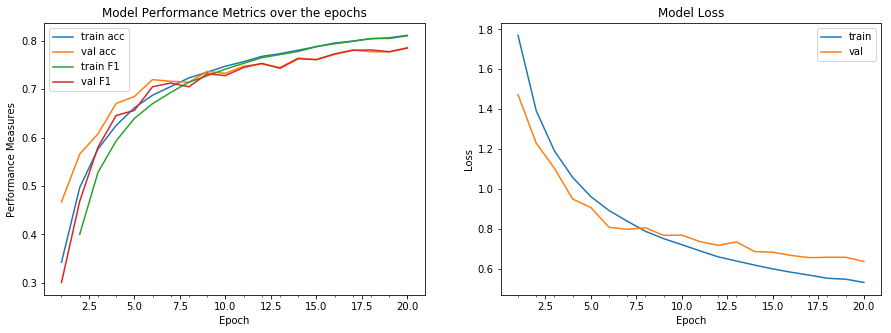

RESNET Model took 25.23 seconds to predict test set


In [156]:
# plot model history
plot_model_history(model_info)
# prep the held out dataset 
xHeldOut = np.rot90(np.reshape(holdOutRawFeatures, (10000,32,32,3), order='F'), axes=(2,1))
# compute accuracy on held out dataset
start = time.time()
y_predicted = RESNET_Predict(model=modelResnet,test_x=xHeldOut)
print("RESNET Model took %0.2f seconds to predict test set"%(time.time() - start))

 ### Performance on hold out dataset

Accuracy of model is: 78.34
             precision    recall  f1-score   support

   airplane       0.80      0.82      0.81      1000
 automobile       0.90      0.90      0.90      1000
       bird       0.71      0.65      0.68      1000
        cat       0.62      0.56      0.59      1000
       deer       0.77      0.76      0.76      1000
        dog       0.65      0.73      0.69      1000
       frog       0.83      0.85      0.84      1000
      horse       0.81      0.84      0.82      1000
       ship       0.86      0.89      0.88      1000
      truck       0.88      0.84      0.86      1000

avg / total       0.78      0.78      0.78     10000



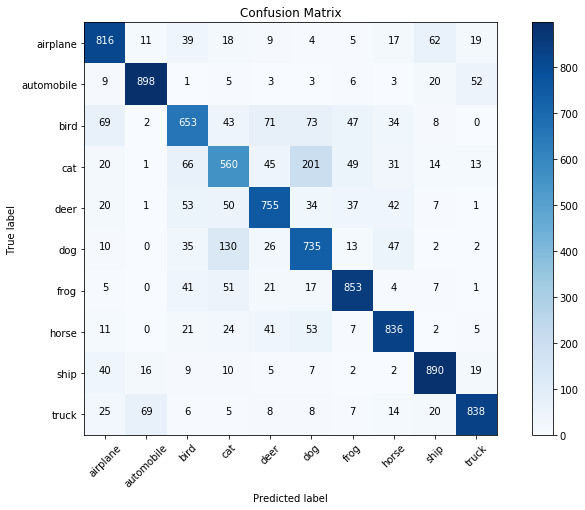

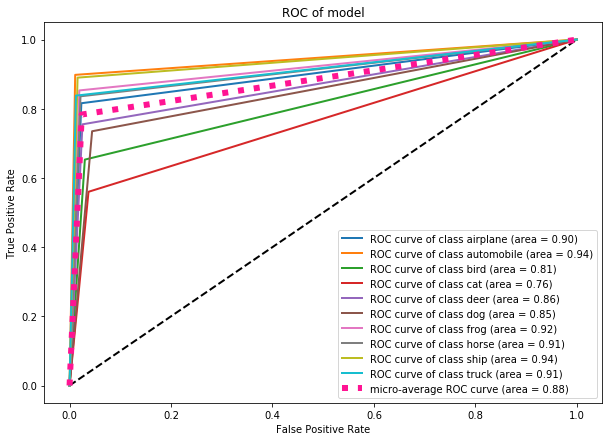

In [157]:
# evaluate the model 
EvaluateModel(y_pred=y_predicted, y_test=holdOutLabels)

In [158]:
# Save the final resnet model 
_MODEL_NAME = "cifar10_resnet_v1"
modelResnet.save(_KERAS_BASE_PATH + _MODEL_NAME + ".h5")

with open(_KERAS_BASE_PATH + "/cifar10_resnet_v1_model_summary", 'wb') as fo:
    modelSummary = model_info.history
    pickle.dump(modelSummary, fo)

# Summary of Model Comparisons

In [ ]:
# load the model performance stats manually curated from the activities above
import pandas as pd
mpg1= pd.read_csv("ModelComparison.csv") # model comparison stats
mlist = ["CNN", "BOVW + SVM Radial", "BOVW + SVM Linear", "Daisy + SVM Linear","ResNet","RNN - GRU","RNN - LSTM"]
mpg1_select  = mpg1.query('Model==@mlist')

In [ ]:
##### from altair import *
import altair as alt
alt.renderers.enable('notebook')

chart = Chart(mpg1_select, width=600,
    height=600
)

#chart.configure_axisX(labelAngle=45)
#chart.configure_circle(cursor= 'nw-resize')

chart.configure_axis(labelFontSize=15,grid=True).configure_axisX(labelAngle=45).mark_circle().encode(
    x='Parameter',
    y='Model',
    size='Value',
    color='Model'
    )

# References 

1.	Multi Layer Neural Network – Stanford University - http://ufldl.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks/ 
2.	Pooling Overview – Stanford University - http://ufldl.stanford.edu/tutorial/supervised/Pooling/ 
3.	Feature extraction using convolutions – Stanford University - http://ufldl.stanford.edu/tutorial/supervised/FeatureExtractionUsingConvolution/ 
4.	DAISY: An Efficient Dense Descriptor Applied to Wide Baseline Stereo
Engin Tola, Vincent Lepetit, Pascal Fua
IEEE Transactions on Pattern Analysis and Machine Intelligence
Vol. 32, Nr. 5, pp. 815 - 830, May 2010
5.	Visual categorization with bags of keywords 
G Csurka, C Dance, L Fan, J Willamowski, C Bray
Workshop on statistical learning in computer vision, ECCV 1 (1-22), 1-2
6.	A beginners guide to understanding conv nets - 
https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/
7. Image Classification in Python using BoVW - Ian London 
https://ianlondon.github.io/blog/how-to-sift-opencv/
8. Bag of Visual Words for Image Classification & recognition 
https://kushalvyas.github.io/BOV.html 
9. Convolutional Neural Network for Image Classification
https://cs231n.github.io/convolutional-networks/ 
10. An overview of Resnets and its variants 
https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035 
11. Resnet example with Keras (Examples)
https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py 
12. ConvNet for Cifar10 by Preneet Kaur
http://parneetk.github.io/blog/cnn-cifar10/ 
13. Normalised RGB 
http://aishack.in/tutorials/normalized-rgb/ 
14. Bags of Visual Words Model 
http://iplab.dmi.unict.it/furnari/teaching/2017-2018/social-media-management/lab2_bag_of_visual_words/index.html 
15. Daisy Feature Extraction
http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_daisy.html#sphx-glr-auto-examples-features-detection-plot-daisy-py 